# Thermal Image generation to help Covid-19 test or any other flu test
> Can Deep learning based  Image translation based method help us to use PCR tests efficiently?

***contact: sezan92[at]gmail[dot]com***

![Image](pix2pix_results.png)

***Let me give the disclaimer first: I am not sure this method will work 100%.*** This blog is not a detailed explanation of ***Pix2Pix*** Image translation! It is just overall look

Image translation is a very powerful method in Deep learning. It can be used to make color images from BW. It can be used to generate image from the sketch. Why not we use it to fight Covid-19?

***Let me explain***

One of the most common problems we faced during this Covid-19 pandemic, is to test people if they have Covid-19 virus or not!. Why ? As it is a new virus, we dont have enough amount of kits! So for many countries - developed as well- it was difficult to test all of its people! So I was thinking, how can my little knowledge in Deep learning help them? One way, is to use the X-ray data of Covid-19 patients and segment the lungs affected by influenza! But there are many problems with this issue. First, Medical Data , are always scarce compared to other dataset. Second, I am not an expert. So handling this sensitive data in this crisis situation is not for me. What if my model - which is black box model and cannot explain why does it work ***yet***- goes wrong for one patient and he ***DIES BECAUSE OF ME?*** No way!

So I got another Idea- thanks to God- . What i say many airports installed Thermal cameras for checking the temperatures of the people coming in. The idea is to check if someone has a fever, they will test him , isolate him , or whatever etc etc. It will make sure , they can selectively test the people who need it most! But it is harder to install thermal cameras all over the country in such a short period of time! So I got an idea! Why dont we use Image translation method to generate thermal images from the RGB images! We already have a lot of surveilance cameras around us. Just use those RGB image!

### Previous works

To the best of my knowledge - and googling capability- I found [this guy](https://medium.com/@hannesliik/thermal-image-generation-from-rgb-b152efa66cc2) doing the same thing. After that I got a lot of confidence doing the same works. In fact the reason for choosing pix2pix network is this blog. Also in the original pix2pix [paper](https://arxiv.org/pdf/1611.07004.pdf), there was an experiment mentioned where RGB images were generated from thermal images , albeit from a different dataset. So I thought, what if the reverse is true? 

## But is it accurate ?

Obviously no! It is just an approximation! But it is better short term solution than testing nobody! So I searched if there are already some works done or not!

## Let's start coding!

My full code is based on [Keras-Gan](https://github.com/eriklindernoren/Keras-GAN) .I just adjusted the codes for my dataset

### Dataloader Class

At first , we make the class for data loading 

importing necessary library

In [1]:
import scipy
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import skimage
import os
import cv2
import random


In [2]:
class DataLoader():
    def __init__(self, dataset_name, img_res=(128, 128),
                 rgb_dataset_folder="/floyd/input/flir_adas/train/RGB",
                 thermal_dataset_folder="/floyd/input/flir_adas/train/thermal_8_bit"):
        self.dataset_name = dataset_name
        self.img_res = img_res
        self.rgb_dataset_folder=rgb_dataset_folder
        self.thermal_dataset_folder=thermal_dataset_folder
        self.rgb_images_list=[image_name for image_name in os.listdir(self.rgb_dataset_folder) if image_name.endswith("jpg")]
    def load_samples(self,num_imgs=32,thermal_ext=".tiff"):
        rgb_imgs,thermal_imgs=[],[]
        random_rgb_image_name_list=np.random.choice(self.rgb_images_list,size=num_imgs).tolist()
        for rgb_img_name in random_rgb_image_name_list:
            rgb_img_path= os.path.join(self.rgb_dataset_folder,rgb_img_name)
            thermal_img_path=os.path.join(self.thermal_dataset_folder,rgb_img_name.split(".")[0]+thermal_ext)
            rgb_img=self.imread(rgb_img_path)
            thermal_img=self.thermal_imread(thermal_img_path)
            rgb_img = cv2.resize(rgb_img, self.img_res)
            thermal_img = cv2.resize(thermal_img, self.img_res)
            rgb_imgs.append(rgb_img)
            thermal_imgs.append(thermal_img)
        rgb_imgs=np.array(rgb_imgs)/127.5-1
        thermal_imgs=np.array(thermal_imgs)[:,:,:,np.newaxis]/127.5-1
        return rgb_imgs, thermal_imgs

    def load_batch(self, batch_size=1, is_testing=False,thermal_ext=".tiff"):
        

        self.n_batches = int(len(self.rgb_images_list) / batch_size)

        for i in range(self.n_batches-1):
            batch = self.rgb_images_list[i*batch_size:(i+1)*batch_size]
            rgb_imgs, thermal_imgs = [], []
            for img_name in batch:
                rgb_img = self.imread(os.path.join(self.rgb_dataset_folder,img_name))
                thermal_img= self.thermal_imread(os.path.join(self.thermal_dataset_folder,img_name.split(".")[0]+thermal_ext))
                h, w, _ = rgb_img.shape
            
                rgb_img = cv2.resize(rgb_img, self.img_res)
                thermal_img = cv2.resize(thermal_img, self.img_res)

                if not is_testing and np.random.random() > 0.5:
                        rgb_img = np.fliplr(rgb_img)
                        thermal_img = np.fliplr(thermal_img)

                rgb_imgs.append(rgb_img)
                thermal_imgs.append(thermal_img)

            rgb_imgs = np.array(rgb_imgs)/127.5 - 1.
            thermal_imgs = np.array(thermal_imgs)[:,:,:,np.newaxis]/127.5 - 1.

            yield rgb_imgs, thermal_imgs


    def imread(self, path):
        try:
            img= cv2.imread(path)
            img= cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
            return img
        except:
            print(path)
        
    def thermal_imread(self,img_path):
        thermal_img_path= img_path
        thermal_img= skimage.io.imread(thermal_img_path)
        return thermal_img

from above , we see, ```DataLoader``` is  a class taking 4 arguments

- dataset_name: name of the dataset using, here we are using FLIR_ADAS Free [dataset](https://www.flir.com/oem/adas/adas-dataset-form)
- img_res: image resulation , Here we are using (128x128) images
- rgb_dataset_folder: The image path for RGB images
- thermal_dataset_folder: the image path for thermal images


The class has 4 methods

- load_samples: loads random images from the dataset
- load_batch: a generator to load batch of images and labels
- imread: a method to read the RGB images
- thermal_imread: a method to read the thermal images

***NOTE: Here we are using 8 bit thermal images. So the values are from 0 to 255. To normalize we will have to divide by 255 (in case 0-1) . But there are also 16 bit images available in the same dataset. In that case we will have to divide by 65355***

### Pix2pix

The pix2pix is an Image translation method which is actually a GAN architecture. But a bit differently. It has ```U-net``` as Generator and ```PatchGAN``` as discriminator.  The following image explains a bit

![image](pix2pix_paper.png)

### pix2pix class

The class needs ```keras_contrib``` for workingj

In [ ]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git

In [ ]:
import scipy
import cv2
from keras.datasets import mnist
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
import datetime
import matplotlib.pyplot as plt
import sys
from data_loader2 import DataLoader
import numpy as np
import os
SEED=1234
np.random.seed(SEED)

In [7]:
class Pix2Pix():
    def __init__(self,img_rows=256,
                img_cols=256,
                channels=3,
                 thermal_channels=1,
                 dataset_name="flir_rgbdas"
                ):
        # Input shape
        self.img_rows = img_rows
        self.img_cols = img_cols
        self.channels = channels
        self.thermal_channels=thermal_channels
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.thermal_img_shape=(self.img_rows,self.img_cols,self.thermal_channels)

        # Configure data loader
        self.dataset_name = dataset_name
        self.data_loader = DataLoader(dataset_name=self.dataset_name,
                                      img_res=(self.img_rows, self.img_cols),thermal_dataset_folder="/floyd/input/flir_adas/train/thermal_8_bit")


        # Calculate output shape of D (PatchGAN)
        patch = 64 #from the paper
        self.disc_patch = (patch, patch, 1)

        # Number of filters in the first layer of G and D
        self.gf = 64
        self.df = 64

        optimizer = Adam(0.0002,0.5,0.999)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='mse',
            optimizer=optimizer,
            metrics=['accuracy'])

        #-------------------------
        # Construct Computational
        #   Graph of Generator
        #-------------------------

        # Build the generator
        self.generator = self.build_generator()

        # Input images and their conditioning images
        img_thermal = Input(shape=self.thermal_img_shape)
        img_rgb = Input(shape=self.img_shape)

        # By conditioning on B generate a fake version of A
        fake_thermal = self.generator(img_rgb)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # Discriminators determines validity of translated images / condition pairs
        valid = self.discriminator([img_rgb,fake_thermal])

        self.combined = Model(inputs=[img_rgb, img_thermal], outputs=[valid, fake_thermal])
        self.combined.compile(loss=["mse","mae"],
                              loss_weights=[1,100],
                              optimizer=optimizer)

    def build_generator(self):
        """U-Net Generator"""

        def conv2d(layer_input, filters, f_size=4, bn=True):
            """Layers used during downsampling"""
            d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
            d = LeakyReLU(alpha=0.2)(d)
            if bn:
                d = BatchNormalization(momentum=0.8)(d)
            return d

        def deconv2d(layer_input, skip_input, filters, f_size=4, dropout_rate=0):
            """Layers used during upsampling"""
            u = UpSampling2D(size=2)(layer_input)
            u = Conv2D(filters, kernel_size=f_size, strides=1, padding='same', activation='relu')(u)
            if dropout_rate:
                u = Dropout(dropout_rate)(u)
            u = BatchNormalization(momentum=0.8)(u)
            u = Concatenate()([u, skip_input])
            return u

        # Image input
        d0 = Input(shape=self.img_shape)

        # Downsampling
        d1 = conv2d(d0, self.gf, bn=False)
        d2 = conv2d(d1, self.gf*2)
        d3 = conv2d(d2, self.gf*4)
        d4 = conv2d(d3, self.gf*8)
        d5 = conv2d(d4, self.gf*8)
        d6 = conv2d(d5, self.gf*8)
        d7 = conv2d(d6, self.gf*8)

        # Upsampling
        u1 = deconv2d(d7, d6, self.gf*8)
        u2 = deconv2d(u1, d5, self.gf*8)
        u3 = deconv2d(u2, d4, self.gf*8)
        u4 = deconv2d(u3, d3, self.gf*4)
        u5 = deconv2d(u4, d2, self.gf*2)
        u6 = deconv2d(u5, d1, self.gf)

        u7 = UpSampling2D(size=2)(u6)
        output_img = Conv2D(self.thermal_channels, kernel_size=4, strides=1, padding='same', activation='tanh',name="thermal")(u7)

        return Model(d0, output_img)

    def build_discriminator(self):

        def d_layer(layer_input, filters, f_size=4, bn=True,strides=2):
            """Discriminator layer"""
            d = Conv2D(filters, kernel_size=f_size, strides=strides, padding='same')(layer_input)
            d = LeakyReLU(alpha=0.2)(d)
            if bn:
                d = BatchNormalization(momentum=0.8)(d)
            return d

        img_rgb = Input(shape=self.img_shape)
        img_thermal = Input(shape=self.thermal_img_shape)

        # Concatenate image and conditioning image by channels to produce input
        combined_imgs = Concatenate(axis=-1)([img_rgb, img_thermal])

        d1 = d_layer(combined_imgs, self.df, bn=False,strides=2) #128
        d2 = d_layer(d1, self.df*2,strides=2) #64
#         d3 = d_layer(d2, self.df*4,strides=1) #128
#         d4 = d_layer(d3, self.df*8,strides=1) #128
#         d5=  d_layer(d4, self.df*8)
        

        validity = Conv2D(1, kernel_size=4, strides=1, padding='same',name="validity")(d2)

        return Model([img_rgb, img_thermal], validity)

    def train(self, epochs, batch_size=1, sample_interval=1):

        start_time = datetime.datetime.now()

        # Adversarial loss ground truths
        valid = np.ones((batch_size,) + self.disc_patch)
        fake = np.zeros((batch_size,) + self.disc_patch)

        for epoch in range(epochs):
            for batch_i, (imgs_rgb, imgs_thermal) in enumerate(self.data_loader.load_batch(batch_size,thermal_ext=".jpeg")):

                # ---------------------
                #  Train Discriminator
                # ---------------------

                # Condition on B and generate a translated version
                fake_thermal = self.generator.predict(imgs_rgb)

                # Train the discriminators (original images = real / generated = Fake)
                d_loss_real = self.discriminator.train_on_batch([imgs_rgb, imgs_thermal], valid)
                d_loss_fake = self.discriminator.train_on_batch([imgs_rgb, fake_thermal], fake)
                d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

                # -----------------
                #  Train Generator
                # -----------------

                # Train the generators
                g_loss = self.combined.train_on_batch([imgs_rgb, imgs_thermal], [valid, imgs_thermal])

                elapsed_time = datetime.datetime.now() - start_time
                # Plot the progress
                print ("[Epoch %d/%d] [Batch %d/%d] [D loss: %f, acc: %3d%%] [G loss: %f] time: %s" % (epoch, epochs,
                                                                        batch_i, self.data_loader.n_batches,
                                                                        d_loss[0], 100*d_loss[1],
                                                                        g_loss[0],
                                                                        elapsed_time))

                # If at save interval => save generated image samples
                if batch_i % sample_interval == 0:
                    self.sample_images(epoch,batch_i,10)

    def sample_images(self, epoch,batch_i, num_images=5):
        target_folder='images_2020_04_13_2nd_Arch/{}/{}'.format(epoch,batch_i)
        if not os.path.exists(target_folder):
            os.makedirs(target_folder, exist_ok=True)
        r, c = num_images, 3

        imgs_rgb, imgs_thermal = self.data_loader.load_samples(num_images,thermal_ext=".jpeg")
        fake_thermal = self.generator.predict(imgs_rgb)
        np.save(target_folder+"/rgb.npy",imgs_rgb)
        np.save(target_folder+"/original_thermal.npy",imgs_thermal)
        np.save(target_folder+"/fake_thermal.npy",fake_thermal)
        imgs_thermal=0.5*imgs_thermal+0.5
        imgs_rgb=0.5*imgs_rgb+0.5
        fake_thermal=0.5*fake_thermal+0.5



        titles = ['Condition','Original', 'Generated']
        plt.figure(figsize=(5,5))
        fig, axs = plt.subplots(r, c,figsize=[20,20])
        cnt = 0
        for i in range(r):
            axs[i,0].imshow(imgs_rgb[i])
            axs[i,1].imshow(imgs_thermal[i][:,:,0],cmap="hot")
            axs[i,2].imshow(fake_thermal[i][:,:,0],cmap="hot")
            
            for j in range(c):
                axs[i, j].set_title(titles[j])
                axs[i,j].axis('off')
        fig.savefig("images_2020_04_13_2nd_Arch/{}/{}/image.png".format(epoch,batch_i))
        
            
        plt.close()
        self.generator.save_weights("saved_model_2020_04_13_2nd_Arch/{}_batch_{}.h5".format(epoch,batch_i))

Okay! This class needs a lot of explanation!

### The class construction

The class takes 5 arguments to initiate
- img_rows, img_cols, channels, RGB image shape
- thermal_channels. The thermal images have same height and width , But only one channel
- dataset_name="flir_rgbdas"

### Methods

The class has 4 methods

#### ```build_generator```

As the name suggests, it builds the generator. The generator is ```U-net``` structure. ```U-net``` is very much used for image segmentation. If you notice the results, you will find, the initial outputs are more like image segmentations!

```build_discriminator```

As the name suggests, it builds the discriminator of the network. The difference from the traditional GAN network is that, it doesnt give output 0 or 1 or "fake" or "not fake"! Instead, It analyzes an $NxN$ patch of the image and then says if that patch is real or fake! Thats why , authors named it ***PatchGAN***

***What is the best value for ```N```?*** It depends on trial and error. For my experiments, I found out that ```64x64``` works good!

***How to determine patch?*** 

In line ```23-26```

Also in line ```126-127```

To try different sizes of patches, you need to play with different values of strides and paddings

```train```

As usual , train method means training the model!

In [ ]:
gan.train(epochs=200,batch_size=4,sample_interval=100)

What it means, it will train for ```200 epochs```, with ```batch_size 4``` and it will try to generate thermal images after every 100 iteration

The training took a long time. I just saved some results after 5 epochs!

In [10]:
rgb_imgs = np.load("rgb.npy")
gen_thermal_imgs=np.load("fake_thermal.npy")
thermal_imgs=np.load("original_thermal.npy")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Generated Thermal Image')

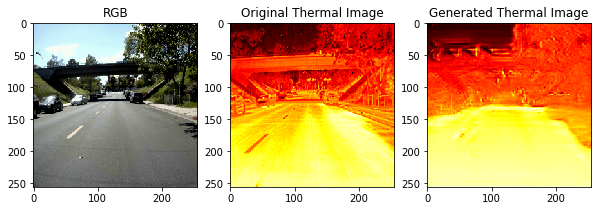

In [39]:
plt.figure(figsize=(10,10))
plt.subplot(131)
plt.imshow(rgb_imgs[0])
plt.title("RGB")
plt.subplot(132)
plt.imshow(thermal_imgs[0][:,:,0],cmap="hot")
plt.title("Original Thermal Image")
plt.subplot(133)
plt.imshow(gen_thermal_imgs[0][:,:,0],cmap="hot")
plt.title("Generated Thermal Image")


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Generated Thermal Image')

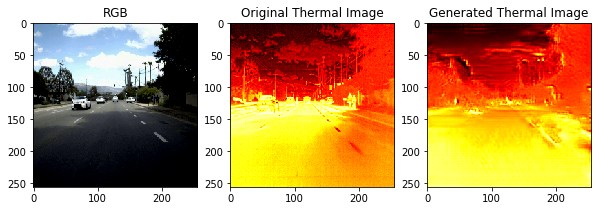

In [40]:
plt.figure(figsize=(10,10))
plt.subplot(131)
plt.imshow(rgb_imgs[5])
plt.title("RGB")
plt.subplot(132)
plt.imshow(thermal_imgs[5][:,:,0],cmap="hot")
plt.title("Original Thermal Image")
plt.subplot(133)
plt.imshow(gen_thermal_imgs[5][:,:,0],cmap="hot")
plt.title("Generated Thermal Image")


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


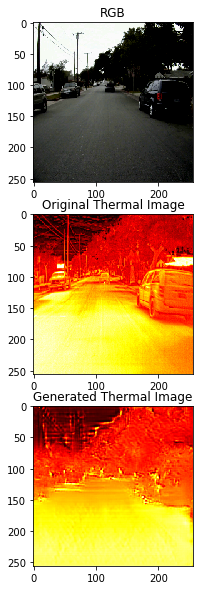

/home/sezan/.local/lib/python3.6/site-packages/matplotlib/backends/backend_gtk3.py:197: Warning: Source ID 11 was not found when attempting to remove it
  GLib.source_remove(self._idle_draw_id)


In [45]:
plt.figure(figsize=(10,10))
plt.subplot(131)
plt.imshow(rgb_imgs[8])
plt.title("RGB")
plt.subplot(132)
plt.imshow(thermal_imgs[8][:,:,0],cmap="hot")
plt.title("Original Thermal Image")
plt.subplot(133)
plt.imshow(gen_thermal_imgs[8][:,:,0],cmap="hot")
plt.title("Generated Thermal Image")
plt.savefig("pix2pix_results.png")


### Result Analysis and way of improvement

If we look at the Generated images, we see, they are not exactly as we clear. Very blurry!! True! It all depends on the ```NxN``` patch values and more dataset! If you see any other mistakes in my part , please feel free to contact via email: sezan92[at]gmail[dot]com I hope and pray this technique to generate Thermal Images may help us .

## Future work

Future works includes, detailed explanation of Image translation methods, Also to get the temperature per pixels from those images and see if it really helps us! 